In [1]:
import pandas as pd
df = pd.read_csv("/Users/lhe/Desktop/438/bitcoin/bitcoin_history.csv")
print(df.head())
print(df.tail())
print(df.columns)

           Date       Open       High        Low      Close  Adj Close  \
0  Feb 20, 2025  96,628.40  98,722.29  96,481.41  98,347.95  98,347.95   
1  Feb 19, 2025  95,532.53  96,855.59  95,011.97  96,635.61  96,635.61   
2  Feb 18, 2025  95,773.81  96,695.38  93,388.84  95,539.55  95,539.55   
3  Feb 17, 2025  96,179.01  97,032.23  95,243.55  95,773.38  95,773.38   
4  Feb 16, 2025  97,580.49  97,725.59  96,060.98  96,175.03  96,175.03   

           Volume  
0  31,327,236,096  
1  28,990,872,862  
2  37,325,720,482  
3  27,336,550,690  
4  16,536,755,396  
              Date    Open    High     Low   Close Adj Close      Volume
3805  Sep 21, 2014  408.08  412.43  393.18  398.82    398.82  26,580,100
3806  Sep 20, 2014  394.67  423.30  389.88  408.90    408.90  36,863,600
3807  Sep 19, 2014  424.10  427.83  384.53  394.80    394.80  37,919,700
3808  Sep 18, 2014  456.86  456.86  413.10  424.44    424.44  34,483,200
3809  Sep 17, 2014  465.86  468.17  452.42  457.33    457.33  21,056,8

In [2]:
import xgboost as xgb
print(xgb.__version__)

1.7.5


In [3]:
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.sort_index()
print(df.isna().sum())
# remove commas from numeric columns and convert to float
for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [4]:
df['ret_1d'] = df['Close'].pct_change()
df['sma_7'] = df['Close'].rolling(7).mean()
df['sma_30'] = df['Close'].rolling(30).mean()
df['sma_diff'] = df['sma_7'] - df['sma_30']
df['volatility_7d'] = df['ret_1d'].rolling(7).std()
df['target'] = df['ret_1d'].shift(-1)  #next day return 
df = df.dropna()

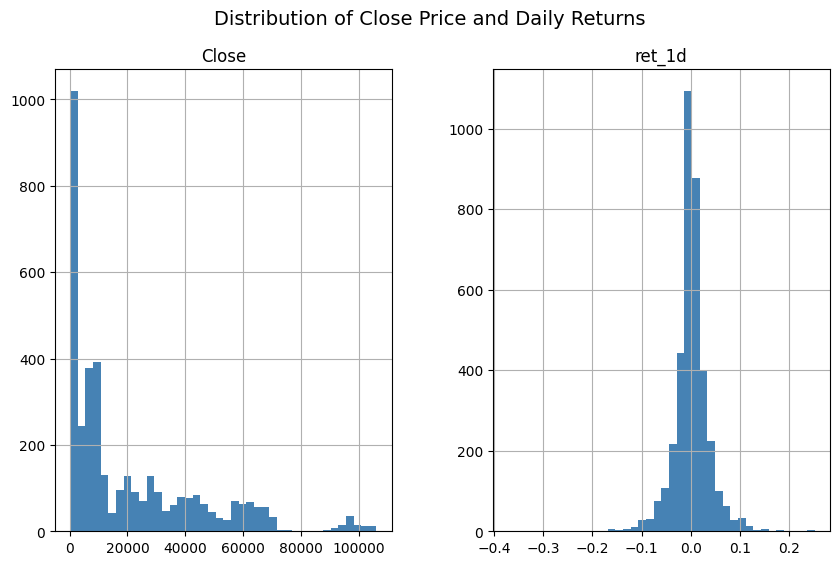

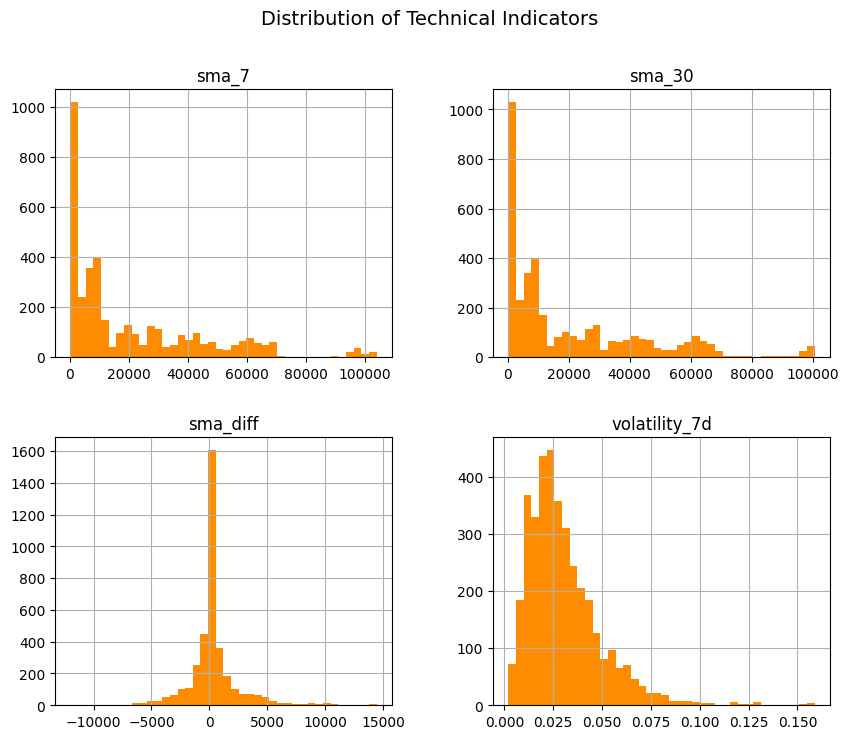

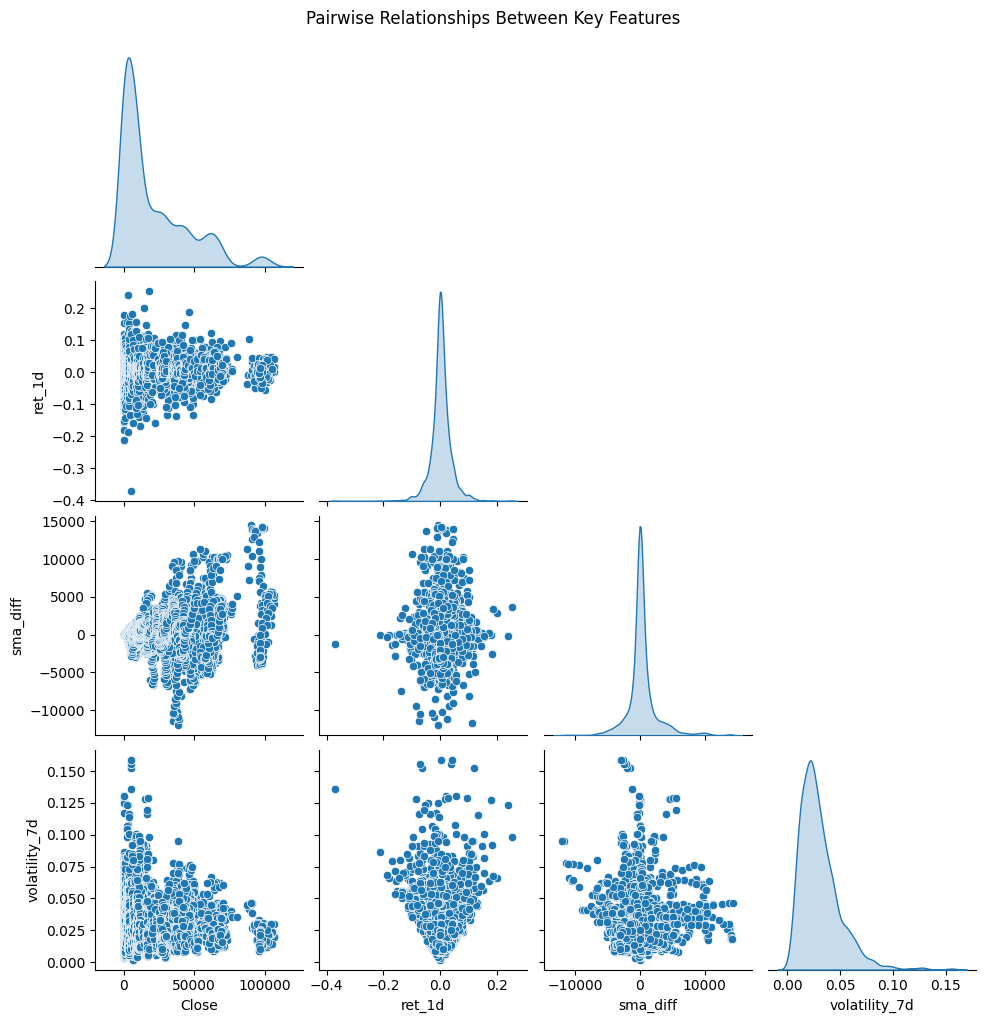

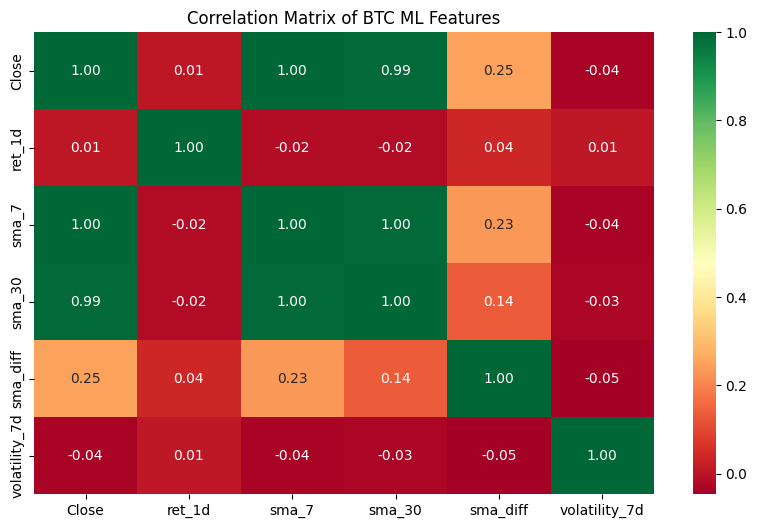

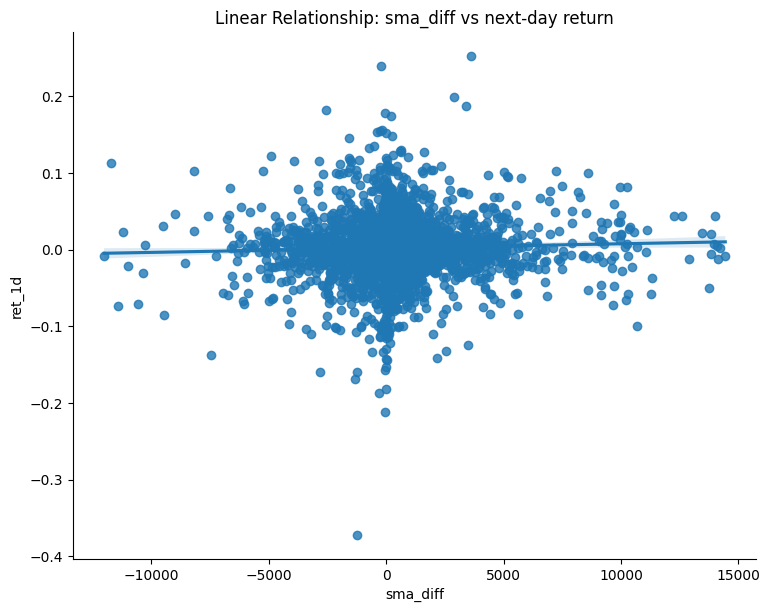

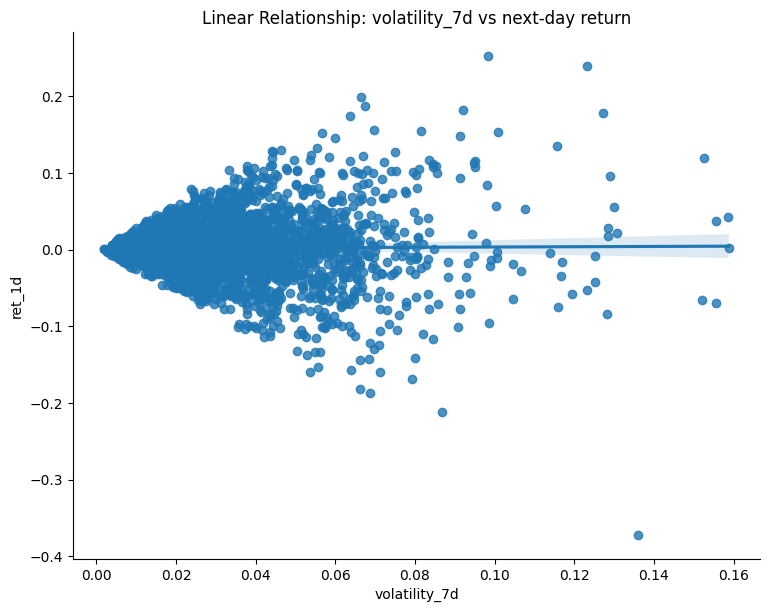

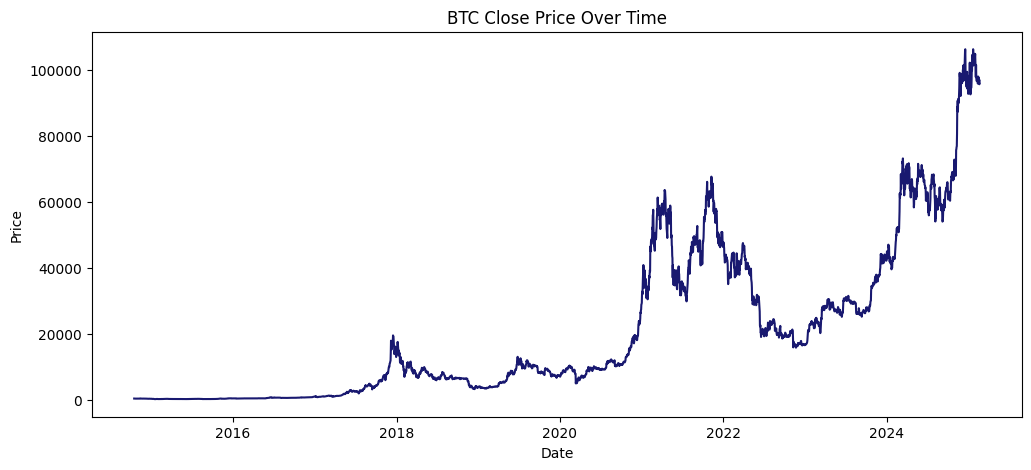

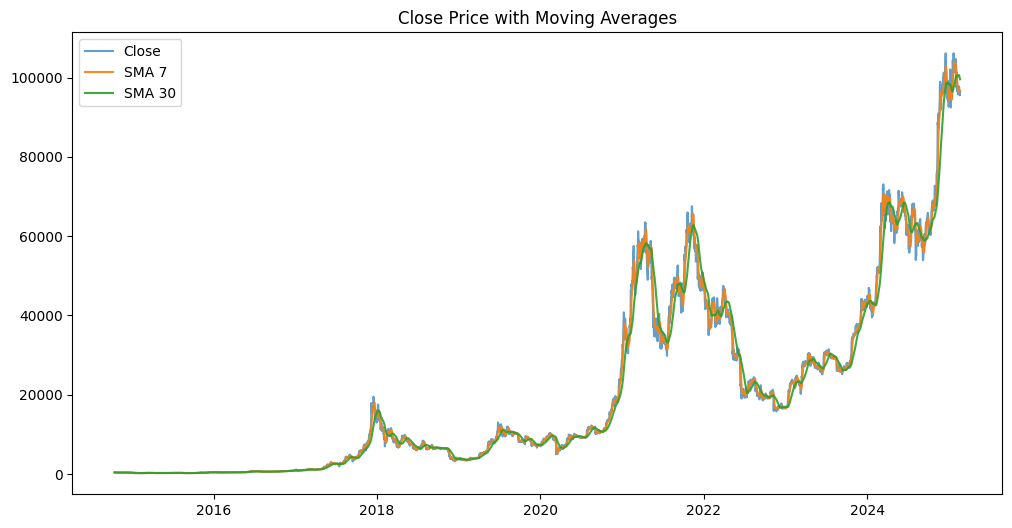

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ===============================
# 2. 原始价格分布与收益分布直方图
# ===============================
df[['Close', 'ret_1d']].hist(figsize=(10,6), bins=40, color='steelblue')
plt.suptitle("Distribution of Close Price and Daily Returns", fontsize=14)
plt.show()

# ===============================
# 3. 技术指标分布
# ===============================
df[['sma_7','sma_30','sma_diff','volatility_7d']].hist(
    figsize=(10,8), bins=40, color='darkorange'
)
plt.suptitle("Distribution of Technical Indicators", fontsize=14)
plt.show()

# ===============================
# 4. Pairplot（模仿 Ensemble 中的 pairplot）
# ===============================
sns.pairplot(
    df[['Close','ret_1d','sma_diff','volatility_7d']],
    diag_kind='kde',
    corner=True
)
plt.suptitle("Pairwise Relationships Between Key Features", y=1.02)
plt.show()

# ===============================
# 5. 相关矩阵（核心部分）
# ===============================
plt.figure(figsize=(10,6))
corr = df[['Close','ret_1d','sma_7','sma_30','sma_diff','volatility_7d',]].corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Correlation Matrix of BTC ML Features")
plt.show()

# ===============================
# 6. 单变量关系图（仿照 sns.lmplot）
# ===============================
sns.lmplot(x='sma_diff', y='ret_1d', data=df, height=6, aspect=1.3)
plt.title("Linear Relationship: sma_diff vs next-day return")
plt.show()

sns.lmplot(x='volatility_7d', y='ret_1d', data=df, height=6, aspect=1.3)
plt.title("Linear Relationship: volatility_7d vs next-day return")
plt.show()

# ===============================
# 7. Close price over time（EDA必备）
# ===============================
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], color='midnightblue')
plt.title("BTC Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# ===============================
# 8. 技术指标可视化
# ===============================
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close', alpha=0.7)
plt.plot(df.index, df['sma_7'], label='SMA 7', alpha=0.9)
plt.plot(df.index, df['sma_30'], label='SMA 30', alpha=0.9)
plt.title("Close Price with Moving Averages")
plt.legend()
plt.show()

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# 选择特征列（可以先用简单三四个）
feature_cols = ['ret_1d', 'sma_diff', 'volatility_7d']

X = df[feature_cols]
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(X_train.shape, X_test.shape)

(3024, 3) (756, 3)


In [7]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 回归误差
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

# 方向预测 accuracy
direction_true = np.sign(y_test.values)
direction_pred = np.sign(y_pred)

direction_accuracy = (direction_true == direction_pred).mean()
print("Directional accuracy:", direction_accuracy)


MSE: 0.0007179041623994486
R²: -0.12199501185234185
Directional accuracy: 0.5066137566137566


In [9]:
# 策略信号：1 = 做多，0 = 空仓
signal = (y_pred > 0).astype(int)

# 实际 next-day return
actual_ret = y_test.values

# 策略收益
strategy_ret = signal * actual_ret

# Buy & Hold 收益（benchmark）
buy_hold_ret = actual_ret

# 累计收益（简单回测）
strategy_curve = (1 + strategy_ret).cumprod() - 1
buy_hold_curve = (1 + buy_hold_ret).cumprod() - 1

print("Final Strategy Return:", strategy_curve[-1])
print("Final Buy & Hold Return:", buy_hold_curve[-1])


Final Strategy Return: 1.6397639506458876
Final Buy & Hold Return: 3.2699122728563337


In [10]:
strategy_mean = np.mean(strategy_ret)
strategy_std = np.std(strategy_ret)

if strategy_std > 0:
    sharpe_like = strategy_mean / strategy_std * np.sqrt(252)
    print("Sharpe-like:", sharpe_like)
else:
    print("Strategy std = 0, cannot compute Sharpe")


Sharpe-like: 1.1343196824970967


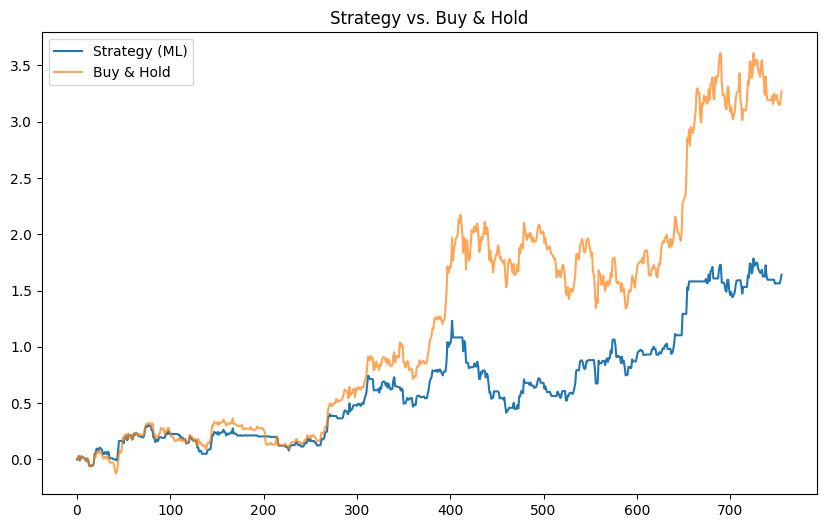

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(strategy_curve, label='Strategy (ML)')
plt.plot(buy_hold_curve, label='Buy & Hold', alpha=0.7)
plt.legend()
plt.title("Strategy vs. Buy & Hold")
plt.show()


#add more references / notes to d\guide what you did here and at the end give some conclusions 
# about the result(like why it fails--> here because our buy-sell strategy is not working as bitcoin 
# price keep increasing, and time series cross-val is hard to figure out by one day record, better try 7-day return etc, or other)